In [1]:
import numpy as np
import pandas as pd
import igraph as ig
from  importlib import resources
import vmlab

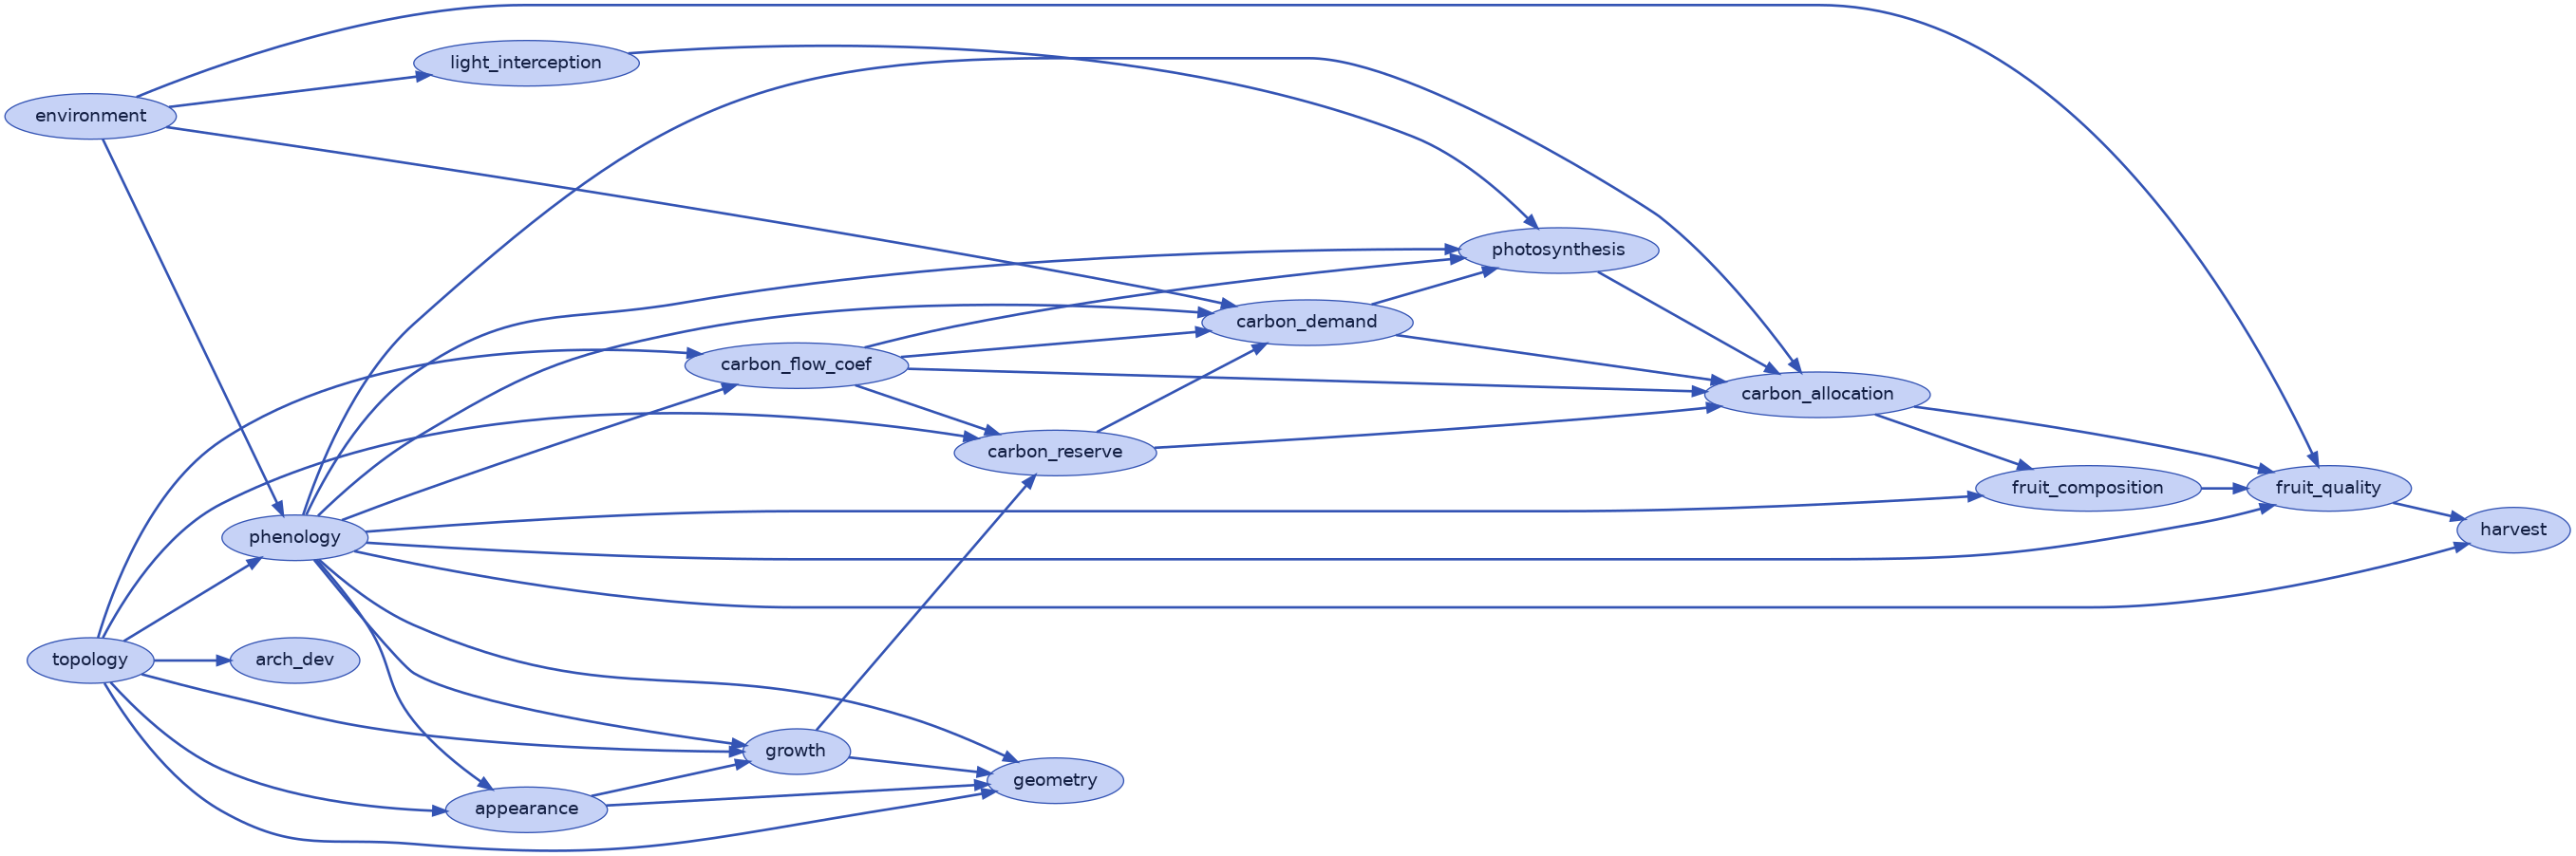

In [2]:
from vmlab.models import fruit_model
from vmlab.processes import harvest
fruit_model = fruit_model.update_processes({'harvest': harvest.HarvestByQuality})
fruit_model.visualize()

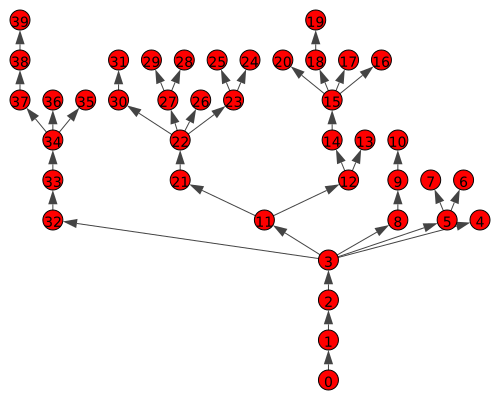

In [3]:
with resources.path('vmlab.data.trees', 'branch_G3.csv') as path:
    tree = pd.read_csv(path)
    graph = vmlab.load_graph(tree)
    vmlab.check_graph(graph)
    layout = graph.layout_reingold_tilford()
    layout.rotate(-180)

ig.plot(graph, bbox=(0,0,500,400), layout=layout, vertex_label=graph.vs.get_attribute_values('name'))

In [4]:
setup = vmlab.create_setup(
    model=fruit_model,
    tree=tree,
    start_date='2002-06-01',
    end_date='2003-06-01',
    setup_toml='fruit_model_branch.toml',
    current_cycle=3,
    input_vars={
        'growth__leaf_senescence_enabled': False,
        'carbon_flow_coef__max_distance_to_fruit': 3,
        'geometry__interpretation_freq': 1
    },
    output_vars={
        'topology': {
            'adjacency': 'day'
        },
        'environment': {
            'TM_day': 'day',
            'RH_day': 'day'
        },
        'carbon_allocation': {
            'DM_fruit': 'day',
            'DM_fleshpeel': 'day',
            'DM_flesh': 'day'
        },
        'carbon_flow_coef': {
            'distances': 'day'
        },
        'harvest': {
            'ripeness_index': 'day',
            'nb_fruit_harvested': None
        },
        'growth': {
            'nb_leaf': None,
        },
        'fruit_quality': {
            'FM_fruit': 'day',
            'W_fleshpeel': 'day',
            'W_flesh': 'day',
            'transpiration_fruit': 'day',
            'osmotic_pressure_fruit': 'day',
            'turgor_pressure_fruit': 'day',
            'water_potential_fruit': 'day',
            'flux_xylem_phloem': 'day',
            'sucrose': 'day'
        }
    }
)

In [5]:
ds_out = vmlab.run(setup, fruit_model, geometry=True)

SceneWidget(scenes=[{'id': 'TEpuXGsAq4lM83uAGha6Lwk9t', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 

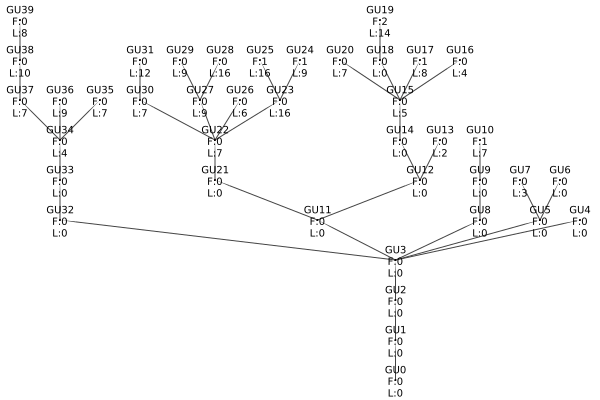

In [6]:
# re-generate graph from the model's adjacency matrix (GU ids and intital tree vertex ids may not be identical)
g = ig.Graph.Adjacency([row.tolist() for row in ds_out.topology__adjacency[-1].data.astype(np.int64)])
layout = g.layout_reingold_tilford(root=0.)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(600, 400),
    vertex_size=1,
    vertex_label_size= 10,
    edge_arrow_width=0.1,
    vertex_label=[
        f'GU{idx}\nF:{int(ds_out.harvest__nb_fruit_harvested.data[idx])}\nL:{int(ds_out.growth__nb_leaf.data[idx])}' for idx in g.vs.indices
    ]
)

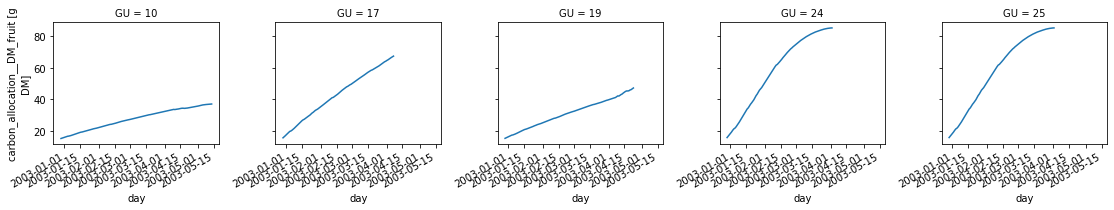

In [7]:
ds_out.carbon_allocation__DM_fruit.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).plot(col='GU', col_wrap=6)

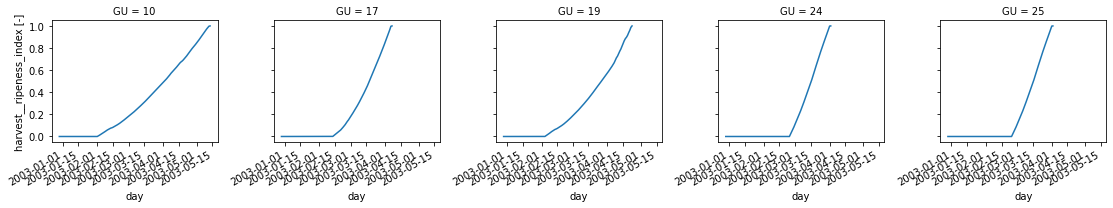

In [8]:
ds_out.harvest__ripeness_index.where(ds_out.carbon_allocation__DM_fruit > 0, drop=True).plot(col='GU', col_wrap=6)

## Visualize carbon flows

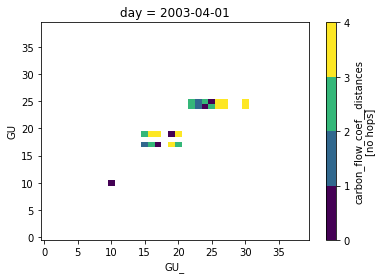

In [9]:
ds_out.carbon_flow_coef__distances.sel({'day': '2003-04-01'}).plot(levels=[0, 1, 2, 3, 4])

In [10]:
# extract coef form a certain date
carbon_flow_coef__distances = ds_out.carbon_flow_coef__distances.sel({'day': '2003-04-01'}).data
edges = np.nonzero(np.isfinite(carbon_flow_coef__distances))

In [11]:
graph_carbon_flow = ig.Graph.Adjacency([row.tolist() for row in ds_out.topology__adjacency[-1].data.astype(np.int64)])
layout2 = graph_carbon_flow.layout_reingold_tilford()
layout2.rotate(-180)

In [12]:
graph_carbon_flow.add_edges(np.flip(np.transpose(edges), axis=1).astype(np.int64), {'distance': carbon_flow_coef__distances[edges]})

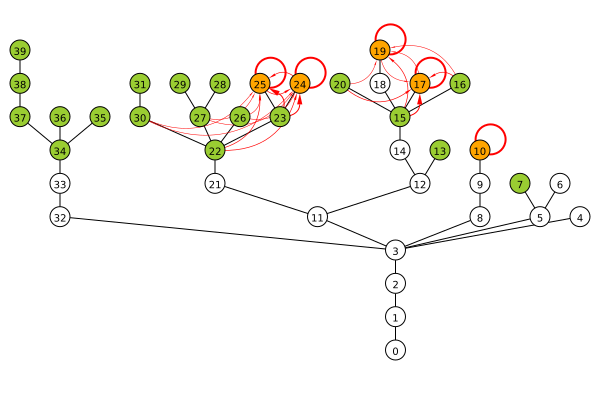

In [13]:
ig.plot(graph_carbon_flow, layout=layout2, bbox=(600, 400), margin=(20,50,20,50),
    vertex_size=20,
    vertex_label_size=10,
    vertex_label=graph.vs.get_attribute_values('name'), # use the original vertex ids (stored as vertex names) from the input dataframe. 
    vertex_color=['orange' if f > 0 else 'YellowGreen' if l > 0 else 'white' for f, l in zip(ds_out.harvest__nb_fruit_harvested.data, ds_out.growth__nb_leaf.data)],
    edge_arrow_width=[1.5/(d+1) if d is not None else 0.1 for d in graph_carbon_flow.es.get_attribute_values('distance')],
    edge_arrow_size=[1.5/(d+1) if d is not None else 0.01 for d in graph_carbon_flow.es.get_attribute_values('distance')],
    edge_color=['red' if d is not None else 'black' for d in graph_carbon_flow.es.get_attribute_values('distance')],
    edge_curved=[0.5 if d is not None else 0 for d in graph_carbon_flow.es.get_attribute_values('distance')],
    edge_width=[2/(d+1) if d is not None else 1 for d in graph_carbon_flow.es.get_attribute_values('distance')]
)